
# 주제 : Seq2Seq의 Encoder로 뉴스기사 토픽 예측하기
--------------
## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## 데이터 소개
    - 이번 주제는 뉴스기사 데이터는 reuters Dataset을 사용합니다.
    - reuters Dataset은 11,228개의 뉴스기사와 46개의 주제를 가지고 있습니다.
    - 모든 단어는 빈도에 따른 정수로 교체 되어있습니다.
    - 관례적으로 정수 0은 특정 단어를 나타내는 것으로 사용하지 않습니다.
    - 학습 데이터와 정답 데이터는, 각각의 아래와 같습니다.
    
    1. train_text
      [
        [1,20, 432, 12, 312, ...],
        [42, 21, 111, 1213, ...],
        ...
      ]
    
    2. train_answer
      [
         3,  4,  3, ..., 25,  3
      ]

    
- 데이터 출처: [reuters](https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection)


## 최종 목표
    - Seq2Seq 기반 모델의 이해
    - word embedding 이해
    - 시계열 데이터 학습 이해
    
  - 출제자 : 손근영 강사


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## Step 1. 도입전 기본 처리

### 문제 1. reuters 데이터 살펴보기

In [2]:
# 데이터를 불러오는 코드를 작성해주세요.
reuters = tf.keras.datasets.reuters
(train_text, train_topic), (test_text, test_topic) = reuters.load_data()

2121728/2110848 [==============================] - 0s 0us/step


### 문제 2. train_text/topic와 test_text/topic의 shape을 출력해보세요.

In [3]:
# 데이터의 크기를 shape 함수를 통해 출력해주세요.
print(train_text.shape, train_topic.shape)
print(test_text.shape, test_topic.shape)

(8982,) (8982,)
(2246,) (2246,)


In [4]:
# train_text/topic의 dtype을 출력해보세요.
print(train_text.dtype, train_topic.dtype)
print(test_text.dtype, test_topic.dtype)

object int64
object int64


### 문제 3. train_text에서 각 원소의 길이를 y축으로 bar plot를 그려보세요.

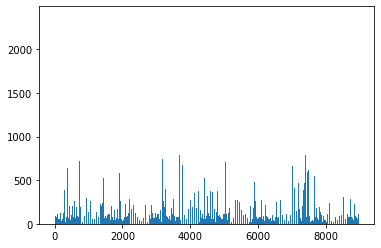

In [6]:
# train_text에서 각 원소의 길이를 y축으로 bar plot를 그려보세요.
plt.bar(range(len(train_text)), [len(text) for text in train_text])
plt.show()

## Step 2. 전처리

### 문제 4. train_text, test_text에서 등장한 정수들을 알아보자

In [9]:
# train_text, test_text에서 등장한 정수들을 알아보자
all_words = set([word for text in train_text for word in text]) | set([word for text in test_text for word in text])
print(sorted(all_words)[:5])
print(sorted(all_words)[-5:])

[1, 2, 4, 5, 6]
[30977, 30978, 30979, 30980, 30981]


### 문제 5. train_text와 test_text를 BOW 형태로 변경

In [10]:
# train_text와 test_text를 BOW 형태로 변경하세요.
train_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_text, value=0)
test_bow_text = tf.keras.preprocessing.sequence.pad_sequences(test_text, value=0)

In [11]:
print(train_bow_text.shape, test_bow_text.shape)

(8982, 2376) (2246, 1032)


### 문제 6. train과 test에 나온 word들의 count를 측정해보자

In [13]:
# train과 test에 나온 word들의 count를 측정해보자
from collections import Counter

word_count = Counter()
for text in train_text:
    word_count.update(text)
for text in test_text:
    word_count.update(text)

word_count.most_common(15)

[(4, 82723),
 (5, 42393),
 (6, 40350),
 (7, 33157),
 (8, 29978),
 (9, 29956),
 (10, 29581),
 (11, 20141),
 (12, 16668),
 (13, 15224),
 (14, 15015),
 (15, 13329),
 (16, 12395),
 (1, 11228),
 (17, 11191)]

### 문제 7. word_count를 이용해서 n번 이하로 나온 word를 삭제하여 train과 test를 구성하여보자.

In [15]:
# word_count를 이용해서 n번 미만으로 나온 word를 삭제하여 train과 test를 구성하여보자.
def cut_by_n(texts, n):
    return np.array([[word for word in text if word_count[word] >= n] for text in texts])

In [19]:
train_cut_text = cut_by_n(train_text, 20)
test_cut_text = cut_by_n(test_text, 20)

### 문제 8. pad 추가된 bow 형태로 변화하여 width 길이를 확인해보세요.

In [20]:
# bow 형태로 변화하여 width 길이를 확인해보세요.
train_cut_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_cut_text, value=0)
test_cut_bow_text = tf.keras.preprocessing.sequence.pad_sequences(test_cut_text, value=0)

### 문제 9. train_text/test_text에 길이 제한을 줘서 bow를 생성해보세요.

In [21]:
# train_text/test_text에 길이 제한을 줘서 bow를 생성해보세요.
train_cut_bow_text2 = tf.keras.preprocessing.sequence.pad_sequences(train_cut_text, value=0, maxlen=200)
test_cut_bow_text2 = tf.keras.preprocessing.sequence.pad_sequences(test_cut_text, value=0, maxlen=200)

### 문제 10. topic을 onehot encoding으로 변경해보세요.

In [22]:
# topic을 onehot encoding으로 변경해보세요.
train_onehot_topic = tf.keras.utils.to_categorical(train_topic)
test_onehot_topic = tf.keras.utils.to_categorical(test_topic)

### 문제 11. topic 인덱스를 text label로 변환하는 함수를 만드세요.

In [23]:
#topic 인덱스를 text label로 변환하는 함수를 만드세요.
raw_labels = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

def topic2label(topic):
    return raw_labels[topic]

In [25]:
print(topic2label(30), topic2label(8))

ipi money-supply


## Step 3. 시각화 방법

### 문제 12. train_text의 길이 분포를 출력해보세요.

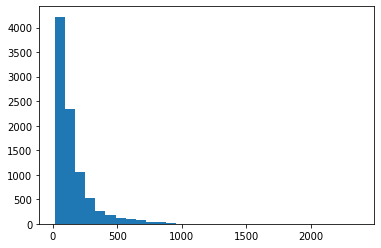

In [27]:
# train_bow_text의 길이 분포를 출력해보세요.
plt.hist([len(text) for text in train_text], bins=30)
plt.show()

### 문제 13. train_cut_bow_text의 길이 분포를 출력해보세요.

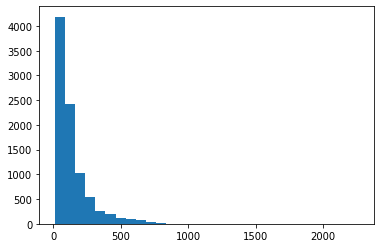

In [28]:
# train_bow_text의 길이 분포를 출력해보세요.
plt.hist([len(text) for text in train_cut_text], bins=30)
plt.show()

### 문제 14. train_cut_bow_text2의 길이 분포를 출력해보세요.

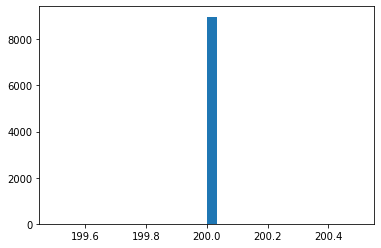

In [30]:
# train_cut_bow_text2의 길이 분포를 출력해보세요.
plt.hist([len(text) for text in train_cut_bow_text2], bins=30)
plt.show()

In [47]:
train_cut_bow_text2.shape

(8982, 200)

### 문제 15. label 분포를 출력해보세요.

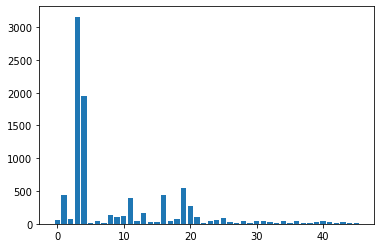

In [36]:
# label 분포를 출력해보세요.
plt.bar(np.unique(train_topic), list(map(lambda x:x[1], sorted(Counter(train_topic).items()))) )
plt.show()

In [37]:
sorted(Counter(train_topic).items())

[(0, 55),
 (1, 432),
 (2, 74),
 (3, 3159),
 (4, 1949),
 (5, 17),
 (6, 48),
 (7, 16),
 (8, 139),
 (9, 101),
 (10, 124),
 (11, 390),
 (12, 49),
 (13, 172),
 (14, 26),
 (15, 20),
 (16, 444),
 (17, 39),
 (18, 66),
 (19, 549),
 (20, 269),
 (21, 100),
 (22, 15),
 (23, 41),
 (24, 62),
 (25, 92),
 (26, 24),
 (27, 15),
 (28, 48),
 (29, 19),
 (30, 45),
 (31, 39),
 (32, 32),
 (33, 11),
 (34, 50),
 (35, 10),
 (36, 49),
 (37, 19),
 (38, 19),
 (39, 24),
 (40, 36),
 (41, 30),
 (42, 13),
 (43, 21),
 (44, 12),
 (45, 18)]

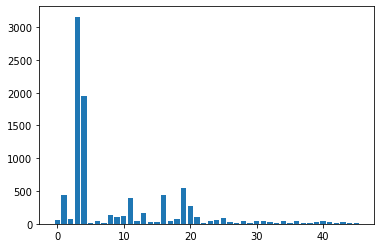

In [38]:
plt.bar(*np.unique(train_topic, return_counts=True))
plt.show()

### 문제 16. seabon을 이용하여 label 분포를 출력해보세요.

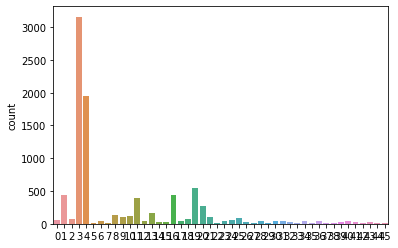

In [39]:
# label 분포를 출력해보세요.
sns.countplot(train_topic)

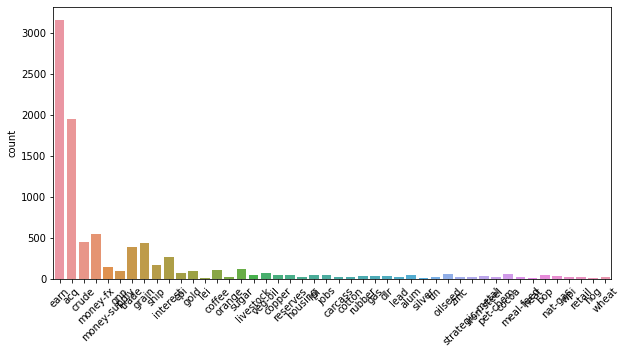

In [40]:
sns.countplot(     list( map(lambda x: topic2label(x),  train_topic  )))
plt.xticks(rotation=45)
fig = plt.gcf()
fig.set_size_inches(10 , 5)
plt.show()

### 문제 17. reuters.get_word_index()를 이용해서 text를 decode해보세요.

In [43]:
# reuters.get_word_index()를 이용해서 text를 decode해보세요.
index2word = { y:x for x,y in reuters.get_word_index().items()}

def bow2text(bow):
    return " ".join([index2word[idx] for idx in bow])

bow2text(test_text[1])

"the slide both their a in after london adjusted 2 contracts 54 as sales agriculture with from were vs been prices its for benefit from dlrs vs been are 2 both 97 firms deficient i geneen briefly mln briefly week operating for giving 28 in record disappointed spending shr initiative around five farmers in but 18 66 5 efforts scale will t net mln with deal from billion vs been said in after london adjusted 5 will agip it take supplies briefly mln 9 confidence on been 5 will agriculture method it in has would both administration without on been it intended figures 3 total on been 5 will 75 that in into shares net mln january in three subject for system guaranty deficient users and 381 surviving in attempt 5 higher prices producers without on been 57 request in executive in three it at china concentrate as sales priorities paris said in attempt last told showed 1 and 48 deficit be what briefly mln surviving over qtr prices today is said acres agree in one news possible be 9 1988 vs region

### 문제 18. train/test 데이터에서 문서당 가장 많은 횟수로 출현한 word 분포를 출력하세요.

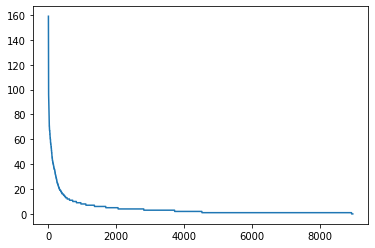

In [44]:
# 문서당 가장 많은 횟수로 출현한 word 분포를 출력하세요.
plt.plot(sorted([np.unique(doc, return_counts=True)[1].argmax() for doc in train_text], reverse=True)) 

### 문제 19. train/test 전체 문서 당 출현이 가장 높은 word 분포를 출력하세요.

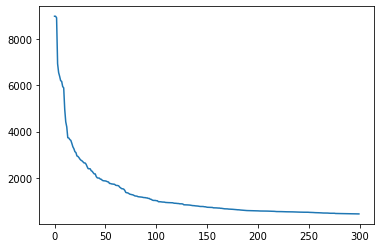

In [45]:
# train/test 전체 문서 당 출현이 가장 높은 word 분포를 출력하세요.
table = np.zeros(len(all_words) + 2)
for doc in train_text:
    table[np.unique(doc)] += 1
plt.plot(sorted(table, reverse=True)[:300])

## Step 4. Seq2Seq의 Encoder 이용 모델링

### 문제 20. Encoder이용 classification 모델 구축

In [52]:
# seq2seq 모델을 구축하고 학습모델, encoder를 획득하세요
from keras.layers import GRU, Input, Embedding, Dense
from keras.models import Model

def seq2seq():
    inputs = Input((200,))
    embedding = Embedding(len(index2word), 120)
    x = embedding(inputs)
    z = GRU(64)(x)
    outputs = Dense(46, activation="softmax")(z)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [46]:
len(index2word)

30979

### 문제 21. 학습 모델을 생성하고 summary를 출력하세요. 

In [53]:
# 학습 모델을 생성하고 summary를 출력하세요.
model = seq2seq()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 120)          3717480   
                                                                 
 gru_2 (GRU)                 (None, 64)                35712     
                                                                 
 dense_2 (Dense)             (None, 46)                2990      
                                                                 
Total params: 3,756,182
Trainable params: 3,756,182
Non-trainable params: 0
_________________________________________________________________


### 문제 22. 모델을 학습해보세요.

In [54]:
# 학습모델을 학습해보세요.
hist = model.fit(train_cut_bow_text2, train_onehot_topic, batch_size=128, validation_data=(test_cut_bow_text2, test_onehot_topic), verbose=1, epochs=20)

Epoch 1/20
71/71 [==============================] - 9s 50ms/step - loss: 2.7169 - accuracy: 0.3361 - val_loss: 2.0978 - val_accuracy: 0.3736
Epoch 2/20
71/71 [==============================] - 3s 38ms/step - loss: 1.9371 - accuracy: 0.4310 - val_loss: 1.8464 - val_accuracy: 0.4969
Epoch 3/20
71/71 [==============================] - 3s 38ms/step - loss: 1.6882 - accuracy: 0.5434 - val_loss: 1.7467 - val_accuracy: 0.5494
Epoch 4/20
71/71 [==============================] - 3s 38ms/step - loss: 1.5624 - accuracy: 0.5910 - val_loss: 1.6818 - val_accuracy: 0.5779
Epoch 5/20
71/71 [==============================] - 3s 38ms/step - loss: 1.4764 - accuracy: 0.6129 - val_loss: 1.6754 - val_accuracy: 0.5757
Epoch 6/20
71/71 [==============================] - 3s 38ms/step - loss: 1.3991 - accuracy: 0.6323 - val_loss: 1.6514 - val_accuracy: 0.5837
Epoch 7/20
71/71 [==============================] - 3s 39ms/step - loss: 1.3345 - accuracy: 0.6510 - val_loss: 1.6437 - val_accuracy: 0.5899
Epoch 8/20
71

### 문제 23. 학습 진행 사항을 plt으로 출력하세요.

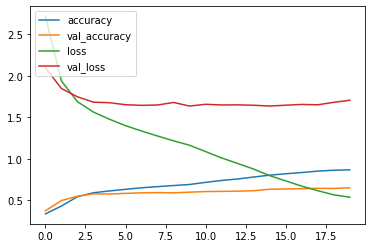

In [55]:
# hist의 accuracy와 loss를 plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc="upper left")
plt.show()

### 문제 24. train_cut_bow_text를 위한 학습 모델을 생성하고 summary를 출력하세요. 

In [56]:
# 학습 모델을 생성하고 summary를 출력하세요.
model2 = seq2seq()
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 200, 120)          3717480   
                                                                 
 gru_3 (GRU)                 (None, 64)                35712     
                                                                 
 dense_3 (Dense)             (None, 46)                2990      
                                                                 
Total params: 3,756,182
Trainable params: 3,756,182
Non-trainable params: 0
_________________________________________________________________


### 문제 25. 학습모델을 학습해보세요. 단, train_cut_bow_text를 200으로 길이를 수정하고 실행하세요.

In [57]:
# 학습모델을 학습해보세요.
hist2 = model2.fit(
    train_cut_bow_text[..., -200:],
    train_onehot_topic,
    validation_data = (test_cut_bow_text[..., -200:], test_onehot_topic),
    verbose = 1,
    epochs=20
)

Epoch 1/20
281/281 [==============================] - 16s 49ms/step - loss: 2.1430 - accuracy: 0.4495 - val_loss: 2.4169 - val_accuracy: 0.5392
Epoch 2/20
281/281 [==============================] - 13s 47ms/step - loss: 1.7362 - accuracy: 0.5708 - val_loss: 1.6842 - val_accuracy: 0.5806
Epoch 3/20
281/281 [==============================] - 13s 47ms/step - loss: 1.5704 - accuracy: 0.5972 - val_loss: 1.6441 - val_accuracy: 0.5899
Epoch 4/20
281/281 [==============================] - 13s 47ms/step - loss: 1.4584 - accuracy: 0.6195 - val_loss: 1.6631 - val_accuracy: 0.5926
Epoch 5/20
281/281 [==============================] - 13s 47ms/step - loss: 1.3520 - accuracy: 0.6458 - val_loss: 1.6440 - val_accuracy: 0.5980
Epoch 6/20
281/281 [==============================] - 14s 49ms/step - loss: 1.2338 - accuracy: 0.6771 - val_loss: 1.6000 - val_accuracy: 0.6171
Epoch 7/20
281/281 [==============================] - 13s 48ms/step - loss: 1.1220 - accuracy: 0.7075 - val_loss: 1.5965 - val_accuracy:

### 문제 26. 학습 진행 사항을 plt으로 출력하세요.

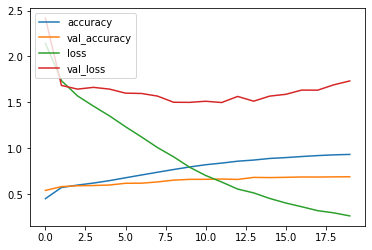

In [58]:
# hist2의 accuracy와 loss를 plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist2.history['accuracy'], label='accuracy')
plt.plot(hist2.history['val_accuracy'], label='val_accuracy')
plt.plot(hist2.history['loss'], label='loss')
plt.plot(hist2.history['val_loss'], label='val_loss')
plt.legend(loc="upper left")
plt.show()

## Step 5. 모델 결과 확인

### 문제 27. 완성된 모델1, 2에서 test 하나를 예측하고 결과를 res1, res2 변수에 저정하세요.

In [59]:
# 완성된 모델에서 test 하나를 예측하고 결과를 res 변수에 저정하세요.
res1 = model.predict(test_cut_bow_text2[1:2])
res1, res1.shape

(array([[3.04488523e-04, 7.58016780e-02, 3.32543701e-02, 3.63421743e-04,
         7.12825824e-03, 1.19316485e-02, 6.59516733e-03, 6.11012336e-04,
         1.71393529e-03, 1.00313006e-02, 4.78408933e-01, 5.87043585e-03,
         8.84432578e-04, 6.48548231e-02, 1.04951225e-02, 2.41884869e-03,
         3.15381698e-02, 1.50370961e-02, 3.47333174e-04, 6.73497911e-04,
         3.28678964e-03, 2.12180102e-03, 3.23733152e-03, 4.48131636e-02,
         1.34034976e-02, 4.12663817e-02, 1.33649691e-03, 7.12111033e-03,
         1.04048792e-02, 1.16607791e-03, 1.18420215e-03, 6.50629774e-02,
         2.97940715e-04, 1.43120624e-03, 2.71187309e-04, 3.30333918e-04,
         7.38568429e-04, 3.60245537e-03, 2.21594935e-03, 1.18292561e-02,
         8.65575578e-03, 1.47711262e-02, 2.20266404e-03, 4.64047451e-04,
         1.13415161e-04, 4.07403306e-04]], dtype=float32), (1, 46))

In [60]:
res2 = model2.predict(test_cut_bow_text[1:2, -200:])
res2, res2.shape

(array([[3.7187008e-05, 1.6210345e-03, 6.4461641e-02, 5.3898868e-04,
         4.7551407e-04, 1.7055135e-03, 2.6696202e-07, 1.1361286e-08,
         6.9686022e-05, 1.8347708e-04, 8.9077187e-01, 1.1472947e-02,
         1.0532756e-04, 2.6708888e-03, 1.7606509e-04, 5.2431756e-06,
         1.9289633e-02, 3.2643246e-05, 1.7412152e-07, 1.6614120e-04,
         1.9783934e-03, 1.3934551e-06, 4.8582544e-04, 1.1949817e-05,
         2.5179069e-03, 1.5017481e-08, 5.6121125e-06, 9.4825867e-07,
         2.0315396e-04, 4.8632234e-08, 2.1717274e-07, 5.7856370e-05,
         1.8087766e-06, 7.9683450e-06, 1.1098203e-09, 2.7980047e-07,
         8.9591500e-05, 4.2386409e-06, 1.1979209e-05, 2.0273367e-07,
         6.9503073e-04, 1.4019637e-04, 7.7164188e-08, 1.4712452e-07,
         1.7958844e-07, 5.4530409e-07]], dtype=float32), (1, 46))

### 문제 28. res1, res2의 결과를 확인하세요.

'sugar'

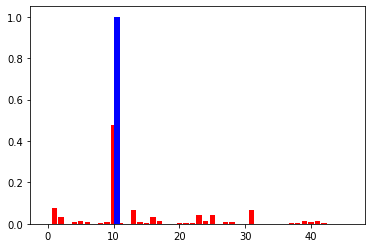

In [61]:
# res1, res2의 결과를 확인하세요.
plt.bar( np.array(range(len(res1[0]))),  res1[0],     color="red" )
plt.bar( np.array(range(len(res1[0]))) + 0.5,  test_onehot_topic[1],     color="blue" )

topic2label( test_onehot_topic[1].argmax() ) 

'sugar'

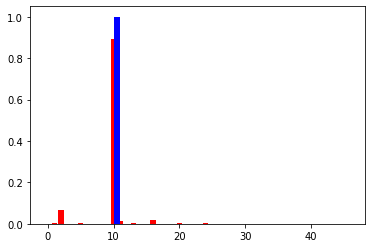

In [62]:
plt.bar( np.array(range(len(res2[0]))),  res2[0],     color="red" )
plt.bar( np.array(range(len(res2[0]))) + 0.5,  test_onehot_topic[1],     color="blue" )

topic2label( test_onehot_topic[1].argmax() ) 

### 문제 29. reuters.get_word_index()를 이용하여 평문을 bow로 변환해보세요. 

In [63]:
# reuters.get_word_index()를 이용하여 평문을 bow로 변환해보세요. (oov는 무시합니다.)
text = bow2text(test_text[0])
text 

'the in wants intermediate 3 how types could mln at against 2 guidelines vs end products opec he will will along results and willingly exports 3 purchased each it stubbornly profit 3 avondale profit agreement in around corp should for 3 cannot mln in ended said avondale a 54 but 3 stubbornly a only generally political primarily date other under well a in british rate gain if demand at an div its taking report montreal systems were is and production had vs 000 7 issued year for 0 a in buffer rate loss may results tariffs dlrs is and from 39 s 000 for 3 cannot pre 50 east that in foods products opec last 1 fall change 1 approval in 15 2 said in opec 28 but for 3 cannot cts systems which is half be 6 iffezheim uobm said president amount pct dlrs'

### 문제 30. text2bow를 이용하여 model1을 통해 결과를 확인하세요.

In [64]:
# text2bow를 이용하여 model1을 통해 결과를 확인하세요.
def text2bow(text, maxlen=400):
    word_index = reuters.get_word_index()
    seq = np.array([word_index[word] for word in text.lower().replace("\n", " ").split() if word in word_index])
    bow = tf.keras.preprocessing.sequence.pad_sequences([seq], value = 0, maxlen = maxlen)
    return bow

In [65]:
bow1 = text2bow(text)
bow1.shape

(1, 400)

In [66]:
bow1

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

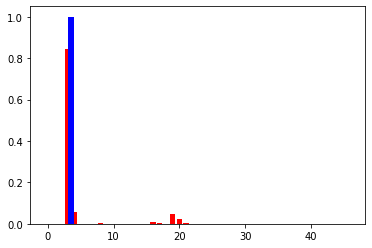

In [68]:
res3 = model.predict(bow1[..., -200:])
plt.bar(np.array(range(len(res3[0]))), res3[0], color="red")
plt.bar(np.array(range(len(res3[0])))+0.5, test_onehot_topic[0], color="blue")
plt.show()

### 문제 31. cut_by_count를 이용하여 20회 이상 등장한 word만 사용하는 bow를 만들어보세요

In [69]:
# cut_by_count를 이용하여 20회 이상 등장한 word만 사용하는 bow를 만들어보세요
bow1_cut = tf.keras.preprocessing.sequence.pad_sequences(cut_by_n(bow1, 20), maxlen=200)
bow1_cut

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    1,    4, 1378, 2025,
           9,  697, 4622,  111,    8,   25,  109,   29, 3650,   11,  150,
         244,  364,   33,   30,   30, 1398,  333,    6,  159,    9, 1084,
         363,   13,   71,    9,   71,  117,    4,  225,   78,  206,   10,
           9, 1214,    8,    4,  270,    5,    7,  748,   48,    9,    7,
         207, 1451,  966, 1864,  793,   97,  133,  336,    7,    4,  493,
          98,  273,  104,  284,   25,   39,  338,   22,  905,  220, 3465,
         644,   59,   20,    6,  119,   61,   11,   15,   58,  579,   26,
          10,   67,    7,    4,  738, 

### 문제 32. text2bow를 이용하여 model1을 통해 결과를 확인하세요.


<BarContainer object of 46 artists>

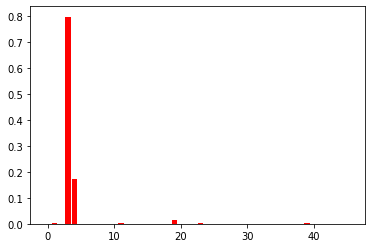

In [70]:
#text2bow를 이용하여 model1을 통해 결과를 확인하세요.
res4 = model2.predict(bow1_cut)
plt.bar(np.array(range(len(res4[0]))), res4[0], color="red")

### 문제 33. confusion 매트릭스 생성

In [71]:
# confusion 메트릭스 출력
from sklearn.metrics import confusion_matrix

conf_mat1 = confusion_matrix(test_onehot_topic.argmax(axis=1), model.predict(test_cut_bow_text2).argmax(axis=1))
print(conf_mat1), conf_mat1.shape

[[ 7  0  0 ...  0  0  0]
 [ 0 74  3 ...  0  0  0]
 [ 0  2 10 ...  0  0  0]
 ...
 [ 1  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  3  0]
 [ 0  0  0 ...  0  0  0]]


(None, (46, 46))

In [72]:
conf_mat2 = confusion_matrix(test_onehot_topic.argmax(axis=1), model2.predict(test_cut_bow_text[...,-200:]).argmax(axis=1))
print(conf_mat2), conf_mat2.shape

[[ 5  0  0 ...  0  0  0]
 [ 0 71  3 ...  0  1  0]
 [ 0  0 13 ...  0  0  1]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  0]]


(None, (46, 46))

### 문제 34. confusion 매트릭스 시각화

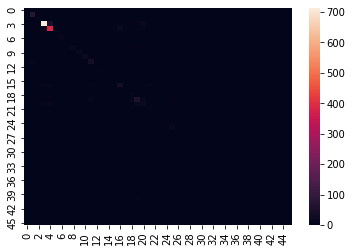

In [73]:
# confusion 매트릭스 시각화
sns.heatmap(conf_mat1)

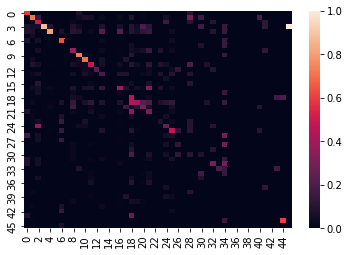

In [74]:
sns.heatmap(conf_mat1 / conf_mat1.sum(axis=1))

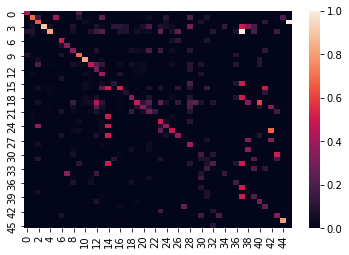

In [75]:
sns.heatmap(conf_mat2 / conf_mat2.sum(axis=1))

### 문제 35. classification 결과 리포팅

In [77]:
# classification 결과 리포팅
from sklearn.metrics import classification_report
print( classification_report(test_onehot_topic.argmax(axis=1), model.predict(test_cut_bow_text2).argmax(axis=1), target_names=raw_labels) )

                 precision    recall  f1-score   support

          cocoa       0.44      0.58      0.50        12
          grain       0.56      0.70      0.62       105
        veg-oil       0.29      0.50      0.36        20
           earn       0.93      0.88      0.90       813
            acq       0.79      0.81      0.80       474
          wheat       0.00      0.00      0.00         5
         copper       0.41      0.64      0.50        14
        housing       0.00      0.00      0.00         3
   money-supply       0.30      0.39      0.34        38
         coffee       0.60      0.72      0.65        25
          sugar       0.60      0.70      0.65        30
          trade       0.47      0.48      0.48        83
       reserves       1.00      0.23      0.38        13
           ship       0.18      0.19      0.18        37
         cotton       0.00      0.00      0.00         2
        carcass       0.00      0.00      0.00         9
          crude       0.35    

In [78]:
print( classification_report(test_onehot_topic.argmax(axis=1), model2.predict(test_cut_bow_text[...,-200:]).argmax(axis=1), target_names=raw_labels) )

                 precision    recall  f1-score   support

          cocoa       0.71      0.42      0.53        12
          grain       0.66      0.68      0.67       105
        veg-oil       0.38      0.65      0.48        20
           earn       0.92      0.90      0.91       813
            acq       0.78      0.82      0.80       474
          wheat       0.00      0.00      0.00         5
         copper       0.54      0.50      0.52        14
        housing       0.50      0.33      0.40         3
   money-supply       0.35      0.34      0.35        38
         coffee       0.57      0.68      0.62        25
          sugar       0.81      0.83      0.82        30
          trade       0.54      0.48      0.51        83
       reserves       0.15      0.31      0.21        13
           ship       0.24      0.41      0.30        37
         cotton       0.00      0.00      0.00         2
        carcass       0.33      0.11      0.17         9
          crude       0.52    

## Step 6. 모델 저장 및 로드, 다운

### 문제 36. 모델을 저장하세요.

In [ ]:
# 모델을 저장하는 코드를 작성하세요. 
model.save('./lecture10.h5')

### 문제 37. 모델 파일을 새로운 모델에 로드하세요.

In [ ]:
# 모델을 로드하는 코드를 작성하세요.
new_model = tf.keras.models.load_model('./lecture10.h5')
new_model.summary()

### 문제 38. 로드한 모델을 test 데이터로 평가해보세요.


In [ ]:
# 로드한 모델을 test 데이터로 평가해보세요.
loss, acc = new_model.evaluate(test_cut_bow_text2, test_onehot_topic, verbose=1)
print(loss, acc)

### 문제 39. 모델을 내 컴퓨터에 저장해보세요

In [ ]:
# 모델을 내 컴퓨터에 저장해보세요.
from google.colab import files
files.download('./lecture10.h5')